<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Extend_dataset_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GO extend dataset YOLOv5**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import pandas as pd
import csv
from random import randint
from time import sleep
import numpy as np
import sys


import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


残り時間 : 11.82

In [ ]:
#テスト画像
test_path = '/content/drive/MyDrive/Deep_learning/Face_Images/IMG_3110.JPG'

# GO_extended_datasetを colab上のフォルダに展開
zip_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_extended_dataset.zip'
!unzip $zip_path -d "/content"
in_path_list  = ['/content/GO_extended_dataset/Control_photo_1886mai', '/content/GO_extended_dataset/treatable']
#保存先フォルダ
out_path_list = ['/content/GO_extended_dataset/cont_for_yolo', '/content/GO_extended_dataset/grav_for_yolo']


#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・横幅を1/4倍、縦幅を上下に1/4倍追加して画像を切り取る（目の全幅、眉毛が含まれるように）

・切り取った画像を横幅640pxにresizeする<br>
・フォルダ内の画像を一括変換して別フォルダに保存

#Haarcascadeを指定

In [ ]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'
# righteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_righteye_2splits.xml'
# lefteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_lefteye_2splits.xml'


# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# righteye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# lefteye_cascade = cv2.CascadeClassifier(eye_cascade_path)

In [ ]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

# def show_image_pillow(img):
#     src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

def scale_to_width(img, width):
    """幅が指定した値になるように、アスペクト比を固定して、リサイズする。
    """
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))

    return dst

In [ ]:
def crop_bilateral(in_path, class_num, size, showImage=True):
    img_resized_list,side_list = [],[]

    img = cv2.imread(in_path) 
    img2 = img.copy()

    if showImage:
        show_image(img)

    # 画像グレースケール化
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #300pix以上のもので目に見えるものを抽出
    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
    print("")
    print('image path = ',in_path)

    # 眼検出判定
    if len(eye_list) >= 1:
        print('目が' + str(len(eye_list)) +'個検出されました')
        pass
    else:
        print("no eye detected")
        pass

    print(f"eye_list: {eye_list}")

    #画像の切り抜きと保存（連番にする）
    if len(eye_list)== 2: 

        
        for (ex, ey, ew, eh) in eye_list:
            print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
            
            try:
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, ey-int(eh/4))
                bottom = min(grayscale_img.shape[0], int(ey + eh*5/4))
                left = max(0,int(ex-int(ew/4)))
                right = min(grayscale_img.shape[1], int(ex + ew*5/4))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                if showImage:
                    show_image(img_cropped)
            except: 
                pass

       
        ex = min(eye_list[0][0], eye_list[1][0])
        ey = min(eye_list[0][1], eye_list[1][1])
        ew = max(eye_list[0][0]+eye_list[0][2], eye_list[1][0]+eye_list[1][2]) - ex
        eh = max(eye_list[0][1]+eye_list[0][3], eye_list[1][1]+eye_list[1][3]) - ey

        print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))

        try:
            cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

            #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
            top = max(0, int(ey-eh/4))
            bottom = min(grayscale_img.shape[0], int(ey+7/6*eh))
            left = max(0,int(ex-ew/10))
            right = min(grayscale_img.shape[1], int(ex + 11/10*ew))

            print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

            img_cropped = img[top: bottom,left:right]
            height, width = img_cropped.shape[:2]

            img_resized = scale_to_width(img_cropped, size) #1辺を指定したpixにresize 

            #クロップした画像を表示
            if showImage:
                show_image(img_resized)
            print(img2.shape)

            #縦、横に対する割合
            X = round((right+left)/2/img2.shape[1], 6)
            Y = round((top+bottom)/2/img2.shape[0], 6)
            W = round((right-left)/img.shape[1], 6)
            H = round((bottom-top)/img.shape[0], 6)
            txt = f"{class_num} {X} {Y} {W} {H}"
            return img_resized, txt

        except:
            print('crop error')


In [ ]:
img, txt = crop_bilateral(test_path, class_num=0, size=640)
print(txt)

with open("test.txt", mode='w') as f:
    f.write(txt)


# #検出された画像を確認
# src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
# plt.imshow(src)


#**Aquisition of bounding boxes**

画像とラベルを指定フォルダに保存

In [ ]:
# orig_folder = "/content/GO_extended_dataset/Control_photo_1886mai" 
# dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO/cont"
# class_num = 0 #classをテキストに書き込む(0:cont, 1:grav)


orig_folder = "/content/GO_extended_dataset/treatable" 
dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO/grav"
class_num = 1 #classをテキストに書き込む(0:cont, 1:grav)

path_list = glob.glob(orig_folder+"/*")
path = path_list[1]
path


'/content/GO_extended_dataset/treatable/5906-20190509-75-102501_1b7f8b82f6c7c4a016f4dae73d0c91cc3e05404f4cdd6eca55b2b48e4dba2c08.jpg'

In [ ]:
path_list = glob.glob(orig_folder+"/*")
#path_list = [path_list[0]] #テスト用
dst_folder = dst_folder

#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/images") #image格納用
os.makedirs(f"{dst_folder}/images_cropped") #cropped_image格納用 (YOLOでは使用しない)
os.makedirs(f"{dst_folder}/labels") #label格納用


num=0
for path in path_list:
    try: #目が検出されなかった場合のエラー回避
        img, txt = crop_bilateral(path, class_num=class_num, size=640, showImage=False)  #両眼抜き出して640pxで保存（crop時にエラーが出るものは削除される）
        img2 = cv2.imread(path).copy()
        img2 = scale_to_width(img2, 640)  #切り抜く前の画像を横のサイズを640になるように縮小
        cv2.imwrite(f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG", img2) #cropせずに縮小したイメージを保存
        cv2.imwrite(f"{dst_folder}/images_cropped/{os.path.basename(path).split('.')[0]}.JPG", img) #cropしたイメージを保存する場合

        with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='w') as f:
            f.write(txt)
        num+=1
    except:
        pass

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")


#**YOLO_v5 training用フォルダを作成**

datasetをtrainとvalに分ける

https://book.st-hakky.com/docs/object-detection-yolov5-tutorial/



In [ ]:
"""

/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
-----dataset-----train-----images
              |         |--labels 
              |--valid-----images
              |         |--labels
              |--dataset.yaml


"""

In [ ]:
# split dataset

import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import shutil

dataset_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO"

def split_dataset(dataset_dir):
    img_list = glob.glob(f"{dataset_dir}/images/*")
    img_train, img_test = train_test_split(img_list, test_size=0.3, random_state=0)

    # img_train, img_testに名前が一致するtxtファイルを抜き出す
    label_train = [f"{dataset_dir}/labels/{os.path.basename(i).split('.')[0]}.txt" for i in img_train]
    label_test = [f"{dataset_dir}/labels/{os.path.basename(i).split('.')[0]}.txt" for i in img_test]

    print(f"train: {len(label_train)},test: {len(label_test)}")

    return img_train, img_test, label_train, label_test


img_train_grav, img_test_grav, label_train_grav, label_test_grav = split_dataset(f"{dataset_dir}/grav")    
img_train_cont, img_test_cont, label_train_cont, label_test_cont = split_dataset(f"{dataset_dir}/cont")    




train: 1159,test: 498
train: 1159,test: 497


In [ ]:
#YOLOv5トレーニング用
#もしdst_folderがあれば削除して新しく作り直す
dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training"

if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
for i in ["train", "valid"]:
    for j in ["images", "labels"]:
        os.makedirs(f"{dst_folder}/{i}/{j}")
        #os.makedirs(f"{dst_folder}/labels")

for file in img_train_grav:
    shutil.copy(file, f"{dst_folder}/train/images/{os.path.basename(file)}")
for file in img_train_cont:
    shutil.copy(file, f"{dst_folder}/train/images/{os.path.basename(file)}")
for file in img_test_grav:
    shutil.copy(file, f"{dst_folder}/valid/images/{os.path.basename(file)}")
for file in img_test_cont:
    shutil.copy(file, f"{dst_folder}/valid/images/{os.path.basename(file)}")
for file in label_train_grav:
    shutil.copy(file, f"{dst_folder}/train/labels/{os.path.basename(file)}")
for file in label_train_grav:
    shutil.copy(file, f"{dst_folder}/train/labels/{os.path.basename(file)}")            
for file in label_test_cont:
    shutil.copy(file, f"{dst_folder}/valid/labels/{os.path.basename(file)}")
for file in label_test_cont:
    shutil.copy(file, f"{dst_folder}/valid/labels/{os.path.basename(file)}") 



In [ ]:
%cd $dst_folder

/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training


In [ ]:
%%writefile dataset.yaml
# path
train: /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images
val: /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images

# num of classes
nc: 2

#class names
names: ['cont', 'grav'] # class名を定義

Overwriting dataset.yaml


#**Setup YOLOv5**

In [6]:
%cd /content
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 31.0/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 15 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/dataset.yaml --weights yolov5n.pt


In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = ""
dst_pt = ""
shutil.copy(orig_pt, dst_pt)

#**YOLOv5 Intereference**

In [ ]:
# Inference (folder内全部)
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images

In [8]:
valid = os.listdir("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images")
train = os.listdir("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images")

print(len(train), len(valid))

2318 995


In [20]:
# Interference (per image)
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt"
image_path = glob.glob("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/*")
img = image_path[2]

In [23]:
!python detect.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt --img 640 --conf 0.25 --source $img

detect: weights=['/content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt'], source=/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/4713-20120831-20-130053_809f5621ff4eda57025be02c14ba15c3c71f40c65a28fa3ae5cfb011c32825c5.JPG, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
image 1/1 /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/4713-20120831-20-130053_809f5621ff4eda57025be0

In [41]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


device = 'cpu'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)
#stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
#imgsz = check_img_size([640], s=stride)  # check image size

class_names = {0:"cont", 1:"grav"}

# transform = transforms.Compose([
#             transforms.Resize(size=(480,640)),
#             transforms.ToTensor(),
#             # transforms.Normalize(
#             #     mean=[0.5, 0.5, 0.5],
#             #     std=[0.5, 0.5, 0.5]
#             #    )
#             ])

img_pil = Image.open(img)  #PILで開く(streamlitの仕様)
img_numpy = np.array(img_pil, dtype=np.uint8)
img_cv2 = cv2.cvtColor(img_numpy, cv2.COLOR_RGB2BGR)



#img_cv2 = cv2.imread(img)
img_cv2 = cv2.resize(img_cv2, dsize=(640, 640)) #480*600pxにリサイズ
img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB

img_cv2 = np.ascontiguousarray(img_cv2)
img_tensor = torch.from_numpy(img_cv2).float()

#img_tensor = transform(img_np)
img_tensor /= 255
print(img_tensor.shape)

print(img_tensor)
img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


pred = model(img_tensor, visualize=False, augment=False)

pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

print(f"pred: {pred}")

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


torch.Size([3, 640, 640])
tensor([[[0.12549, 0.17647, 0.10980,  ..., 0.06275, 0.06275, 0.05490],
         [0.15686, 0.17255, 0.10196,  ..., 0.06275, 0.06275, 0.05882],
         [0.18039, 0.16471, 0.10588,  ..., 0.06667, 0.06275, 0.06275],
         ...,
         [0.27451, 0.32941, 0.36078,  ..., 0.46275, 0.49020, 0.47059],
         [0.27059, 0.30980, 0.35294,  ..., 0.48627, 0.49804, 0.47059],
         [0.26667, 0.29804, 0.34902,  ..., 0.50588, 0.50588, 0.47451]],

        [[0.07451, 0.12549, 0.05882,  ..., 0.04314, 0.04314, 0.03529],
         [0.10588, 0.12157, 0.05490,  ..., 0.04314, 0.04314, 0.03922],
         [0.12941, 0.11373, 0.05882,  ..., 0.04706, 0.04314, 0.04314],
         ...,
         [0.21961, 0.27059, 0.29412,  ..., 0.33333, 0.36078, 0.34118],
         [0.21569, 0.25098, 0.29020,  ..., 0.35686, 0.36863, 0.34118],
         [0.21176, 0.23922, 0.28627,  ..., 0.37647, 0.37647, 0.34510]],

        [[0.15294, 0.19608, 0.12549,  ..., 0.07059, 0.06667, 0.05098],
         [0.18431, 

診断は grav、確率は52.1％です。


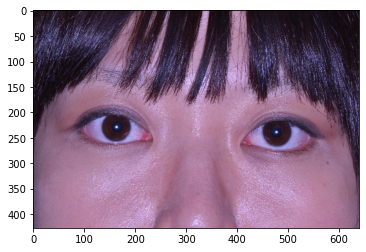

In [31]:
# probability
prob = pred[0][0][4].item()

# class
class_name = class_names[pred[0][0][5].item()]

print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

plt.imshow(np.array(img_pil)